BERT Model

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.15.0


In [ ]:
!git clone --depth 1 -b v2.13.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2224, done.
remote: Counting objects: 100% (2224/2224), done.
remote: Compressing objects: 100% (1594/1594), done.
remote: Total 2224 (delta 713), reused 1018 (delta 594), pack-reused 0
Receiving objects: 100% (2224/2224), 18.47 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (713/713), done.
Note: switching to '6db73770b90aca5e8110478aed79b0fc5d06355c'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [ ]:
!pip install -q six google-api-python-client kaggle numpy oauth2client pandas psutil py-cpuinfo scipy tensorflow-hub tensorflow-model-optimization tensorflow-datasets gin-config tf_slim Cython matplotlib pyyaml opencv-python-headless Pillow pycocotools seqeval sentencepiece sacrebleu immutabledict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.tools import tokenization
from official.nlp import optimization

In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.15.0
Eager mode:  True
Hub version:  0.16.1
GPU is NOT AVAILABLE


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Major Project/Project/code with short length/short length.csv")

In [ ]:
df.shape

(199, 2)

In [ ]:
df["text"] = df['text'].str.lower()

In [ ]:
df.head(5)

,text,generated
0,car-free cities have become a subject of incre...,1
1,"car free cities car-free cities, a concept ga...",1
2,a sustainable urban future car-free cities ...,1
3,pioneering sustainable urban living in an e...,1
4,the path to sustainable urban living in an ...,1


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

(array([ 78.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 121.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

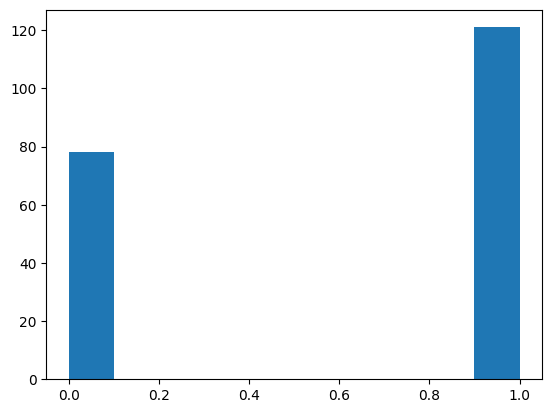

In [ ]:
plt.hist(df['generated'])

In [ ]:
from sklearn.model_selection import train_test_split


train_df, remaining = train_test_split(df, random_state=42, train_size=0.80, stratify=df.generated.values)

num_classes = remaining.generated.nunique()

valid_df, _ = train_test_split(remaining, random_state=42, train_size=max(0.010, num_classes / len(remaining)), stratify=remaining.generated.values)

train_df.shape, valid_df.shape


((7, 2), (2, 2))

In [ ]:
with tf.device('/cpu:0'):

 train_data = tf.data.Dataset.from_tensor_slices((train_df["text"].values, train_df["generated"].values))
 valid_data = tf.data.Dataset.from_tensor_slices((valid_df.text.values, valid_df.generated.values))

 for text, labels in train_data.take(1):
   print(text)
   print(labels)

tf.Tensor(b"the advantages of limiting car usage\n\ncars have long been a symbol of suburban life. however, limiting car usage in favor of alternative transportation methods can have numerous advantages. the passage set provides several examples of these advantages, including reduced greenhouse gas emissions, improved air quality, and increased accessibility to public transportation. by examining these benefits, it becomes clear that limiting car usage can lead to a more sustainable and healthier environment.\n\none advantage of limiting car usage is the reduction of greenhouse gas emissions. the passage states that passenger cars are responsible for a significant amount of greenhouse gas emissions, particularly in car-intensive areas. in europe, passenger cars account for 12 percent of greenhouse gas emissions, and in the united states, the figure can be as high as 50 percent. by limiting car usage and promoting alternative transportation methods such as walking, biking, and public tr

In [ ]:
list_labels = [0,1]
max_seq_length = 512
train_batch_size = 2
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:

def to_feature(text, label, label_list=list_labels, max_seq_length=max_seq_length, tokenizer=tokenizer):
  text_a = text.numpy()
  labels = label.numpy()
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a=text_a,
                                             text_b=None,
                                             label=labels)
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label],
                                                                Tout=[tf.int32,tf.int32,tf.int32,tf.int32])

  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])

  x = {
      "input_word_ids":input_ids,
      "input_mask":input_mask,
      "input_type_ids":segment_ids
  }

  return (x, label_id)

In [ ]:
with tf.device('/cpu:0'):
  train_data = (train_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(100).batch(2, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

  valid_data = (valid_data.map(to_feature_map,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(100).batch(2, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(2, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(2,), dtype=tf.int32, name=None))

In [ ]:
def create_model():

  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="input_type_ids")
  pooled_output, sequence_output = bert_layer([input_word_ids,input_mask,input_type_id])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
      {
          "input_word_ids": input_word_ids,
          "input_mask": input_mask,
          "input_type_ids":input_type_id
      },
      outputs=output)
  return model

In [ ]:
model = create_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss = tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 512)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                              

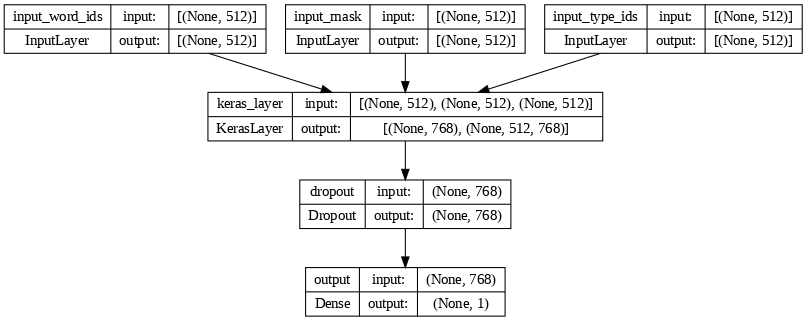

In [ ]:
tf.keras.utils.plot_model(model=model,show_shapes=True, dpi=76)

DO not run this cell

In [ ]:
# Train model
epochs = 3
history = model.fit(train_data,
          validation_data = valid_data,
          epochs = epochs,
          verbose = 1)

Epoch 1/3
3/3 [==============================] - 86s 19s/step - loss: 0.8182 - binary_accuracy: 0.5000 - val_loss: 0.7395 - val_binary_accuracy: 0.5000
Epoch 2/3
3/3 [==============================] - 51s 18s/step - loss: 0.5232 - binary_accuracy: 0.6667 - val_loss: 0.7245 - val_binary_accuracy: 0.5000
Epoch 3/3
3/3 [==============================] - 55s 18s/step - loss: 0.7162 - binary_accuracy: 0.8333 - val_loss: 0.8064 - val_binary_accuracy: 0.5000


In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
model.evaluate(valid_data, verbose=1)

1/1 [==============================] - 6s 6s/step - loss: 0.8064 - binary_accuracy: 0.5000


[0.8063752055168152, 0.5]

In [ ]:
test_essays = pd.read_csv('/content/drive/MyDrive/Major Project/Project/code with short length/short test.csv')

In [ ]:
test_df = test_essays['text']

In [ ]:
test_df.head()

0    The Face on Mars is nothing but a natural occu...
1    Students have a higher chance of catching a vi...
2    Driverless cars have good and bad things that ...
3    Some people might think that traveling in a gr...
4    How many of us students want to be forced to d...
Name: text, dtype: object

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices((test_df, [0]*len(test_df)))
test_data = (test_data.map(to_feature_map).batch(1))
preds = model.predict(test_data)

101/101 [==============================] - 245s 2s/step


In [ ]:
preds

array([[0.51244175],
       [0.6210675 ],
       [0.41658497],
       [0.41944003],
       [0.29151487],
       [0.5072709 ],
       [0.7884351 ],
       [0.30094528],
       [0.28767672],
       [0.8177823 ],
       [0.41507685],
       [0.67032325],
       [0.36383605],
       [0.3775745 ],
       [0.7710464 ],
       [0.31452015],
       [0.727079  ],
       [0.3869154 ],
       [0.39103332],
       [0.39976144],
       [0.3624799 ],
       [0.25031593],
       [0.3588959 ],
       [0.4521921 ],
       [0.4081713 ],
       [0.39549428],
       [0.34730545],
       [0.36936128],
       [0.4348221 ],
       [0.260717  ],
       [0.8479086 ],
       [0.26401234],
       [0.27298594],
       [0.8614377 ],
       [0.34227538],
       [0.79645276],
       [0.36657542],
       [0.3836299 ],
       [0.816276  ],
       [0.6443689 ],
       [0.32710177],
       [0.20336534],
       [0.83052784],
       [0.21838614],
       [0.2850257 ],
       [0.7357535 ],
       [0.43652937],
       [0.659

In [ ]:
test_essays['generated'] = preds

In [ ]:
test_essays.head()

,text,label,generated
0,The Face on Mars is nothing but a natural occu...,0,0.512442
1,Students have a higher chance of catching a vi...,0,0.621068
2,Driverless cars have good and bad things that ...,0,0.416585
3,Some people might think that traveling in a gr...,1,0.419440
4,How many of us students want to be forced to d...,0,0.291515


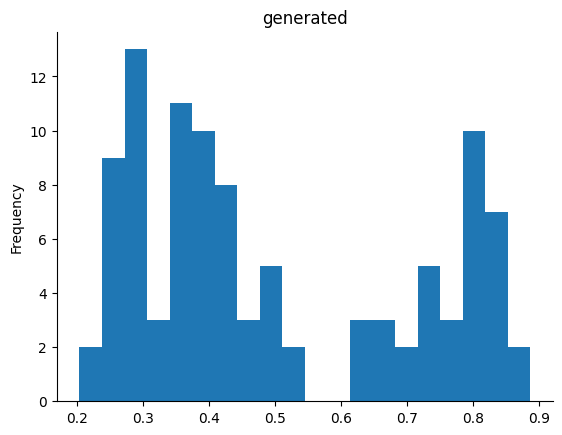

In [ ]:

from matplotlib import pyplot as plt
test_essays['generated'].plot(kind='hist', bins=20, title='generated')
plt.gca().spines[['top', 'right',]].set_visible(False)